In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
from google.cloud import aiplatform
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import spacy

In [2]:
file_path_test = 'medical_cases_test.csv'
df_test = pd.read_csv(file_path_test)
print("✅ Successfully loaded the test dataset.")
print("Dataset preview:")
print(df_test.head())

file_path_train = 'medical_cases_train.csv'
df_train = pd.read_csv(file_path_train)
print("✅ Successfully loaded the train dataset.")
print("Dataset preview:")
print(df_train.head())

file_path_validation = 'medical_cases_validation.csv'
df_validation = pd.read_csv(file_path_validation)
print("✅ Successfully loaded the validation dataset.")
print("Dataset preview:")
print(df_validation.head())

✅ Successfully loaded the test dataset.
Dataset preview:
                                         description  \
0  Complete laminectomy, L4. and facetectomy, L3-...   
1  Loculated left effusion, multilobar pneumonia....   
2  Abnormal echocardiogram findings and followup....   
3  Application of PMT large halo crown and vest. ...   
4  MRI Brain & MRI C-T spine: Multiple hemangiobl...   

                                       transcription  \
0  PREOPERATIVE DIAGNOSIS:,  Dural tear, postoper...   
1  REASON FOR CONSULTATION: , Loculated left effu...   
2  REASON FOR CONSULTATION:  ,Abnormal echocardio...   
3  PREOPERATIVE DIAGNOSES: , Cervical spondylosis...   
4  CC:, Weakness.,HX:, This 30 y/o RHM was in goo...   

                 sample_name           medical_specialty  \
0  Laminectomy & Facetectomy                  Orthopedic   
1       Multilobar Pneumonia  Cardiovascular / Pulmonary   
2    Abnormal Echocardiogram  Cardiovascular / Pulmonary   
3      PMT Halo Crown & Vest 

In [3]:
print(df_train.columns.tolist())


['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']


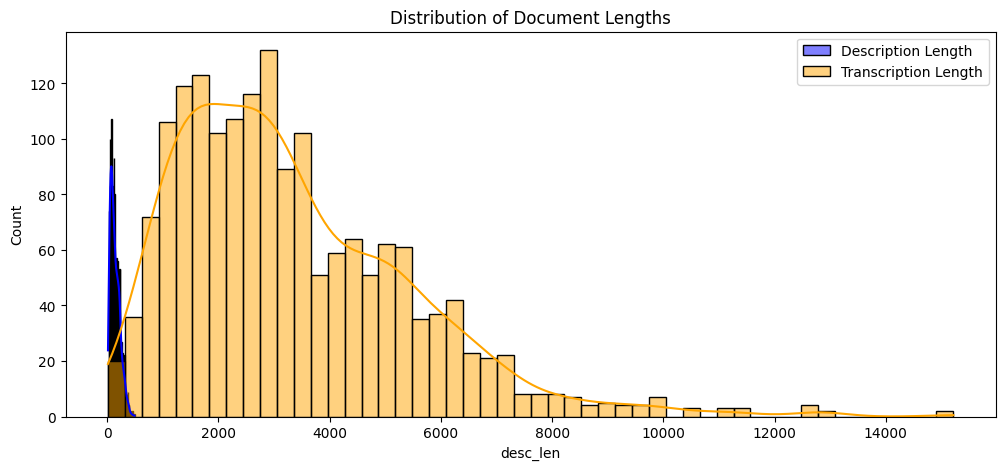

In [4]:
df_train["desc_len"] = df_train["description"].astype(str).apply(len)
df_train["trans_len"] = df_train["transcription"].astype(str).apply(len)

plt.figure(figsize=(12,5))
sns.histplot(df_train["desc_len"], bins=50, kde=True, color="blue", label="Description Length")
sns.histplot(df_train["trans_len"], bins=50, kde=True, color="orange", label="Transcription Length")
plt.legend()
plt.title("Distribution of Document Lengths")
plt.show()

C:\Users\lapcity\AppData\Local\Temp\ipykernel_11684\2648289343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")


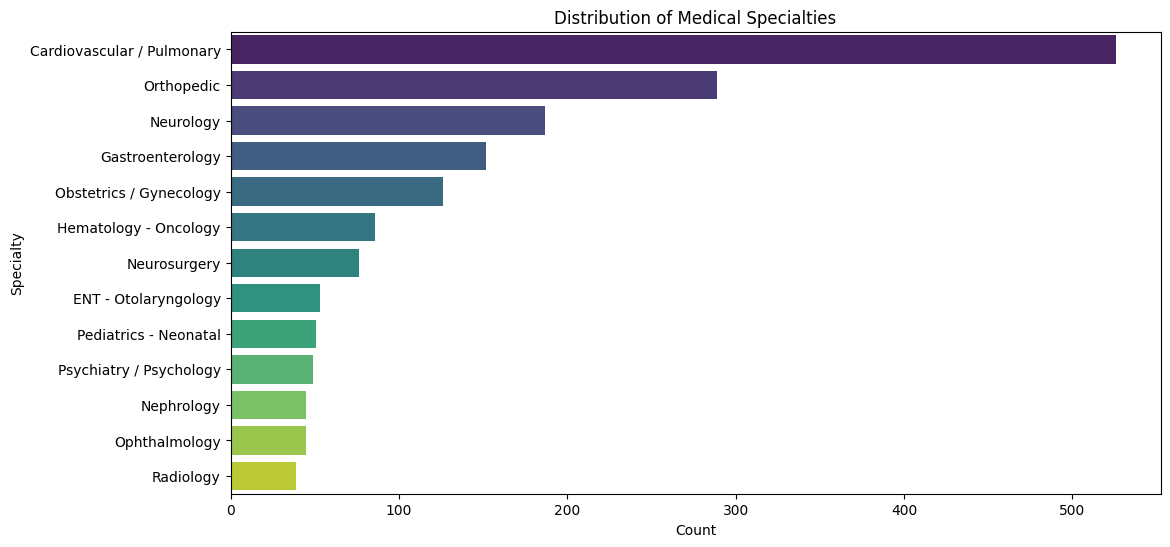

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")
plt.title("Distribution of Medical Specialties")
plt.xlabel("Count")
plt.ylabel("Specialty")
plt.show()


In [6]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def preprocess_text(text):
    doc = nlp(str(text).lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            lemma = token.lemma_.strip()
            if lemma:  # skip empty lemmas
                tokens.append(lemma)
    return " ".join(tokens)

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,           # Redundant now, but fine to keep
        stop_words='english',     # Can be replaced with custom_stopwords
        ngram_range=(1,2),        # Unigrams + bigrams
        max_features=10000        # Limit features
    )),
    ('clf', LogisticRegression(max_iter=1000))
])
#Boost rare classes
ortho_terms = {"fracture", "bone", "joint", "spine"}
neuro_terms = {"seizure", "nerve", "spinal", "brain"}
neurosurg_terms = {"tumor", "craniotomy", "surgery", "lesion"}

specialty_keywords = {
    "Orthopedic": {"fracture", "bone", "joint", "arthroplasty"},
    "Neurology": {"seizure", "epilepsy", "migraine", "neuropathy"},
    "Neurosurgery": {"craniotomy", "aneurysm", "resection", "spinal tumor"},
    "Obstetrics / Gynecology": {"pregnancy", "cervix", "delivery", "menstrual"},
    "Hematology - Oncology": {"chemotherapy", "leukemia", "carcinoma", "oncology"}
}

def boost_keywords(row):
    text = row["clean_transcription"]
    kws = str(row["keywords"]).lower().split()
    boosted = []
    for specialty, terms in specialty_keywords.items():
        for kw in kws:
            if kw in terms:
                boosted.extend([kw] * 8)  # stronger boost
            else:
                boosted.append(kw)
    return text + " " + " ".join(boosted)

# Preprocess once and store
df_train["combined_text"] = df_train["clean_transcription"] + " " + df_train["keywords"].astype(str)
df_validation["combined_text"] = df_validation["clean_transcription"] + " " + df_validation["keywords"].astype(str)
df_test["combined_text"] = df_test["clean_transcription"] + " " + df_test["keywords"].astype(str)

df_train["combined_text"] = df_train.apply(boost_keywords, axis=1)

# Train
pipeline.fit(df_train["combined_text"], df_train["medical_specialty"])

# Evaluate (use clean version here too!)
val_acc = pipeline.score(df_validation["combined_text"], df_validation["medical_specialty"])
test_acc = pipeline.score(df_test["combined_text"], df_test["medical_specialty"])

print(f"📊 Validation Accuracy: {val_acc:.4f}")
print(f"📊 Test Accuracy: {test_acc:.4f}")



📊 Validation Accuracy: 0.7892
📊 Test Accuracy: 0.8216


In [18]:
class_weights = {
    "Orthopedic": 2.0,
    "Neurology": 1.5,
    "Neurosurgery": 1.5,
    # others default 1.0
}
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression(
        multi_class='multinomial',  # Softmax regression
        solver='lbfgs',
        max_iter=1000,
        class_weight=class_weights #give weight to more rare cases
    ))
])

# -----------------------------
# Step 2: Cross-Validation
# -----------------------------
cv_scores = cross_val_score(pipeline, df_train['combined_text'], df_train['medical_specialty'], cv=5, scoring='accuracy')
print(f"📊 Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# -----------------------------
# Step 3: Hyperparameter Tuning (GridSearch)
# -----------------------------
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.8, 0.9, 1.0],   # ignore super-common words
    'tfidf__min_df': [2, 5, 10],        # ignore very rare words
    'tfidf__max_features': [5000, 10000, 20000],  # cap vocab size
    'clf__C': [0.01, 0.1, 1, 10]
}


grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall_macro', n_jobs=-1, verbose=2)
grid.fit(df_train['combined_text'], df_train['medical_specialty'])

print("✅ Best Parameters:", grid.best_params_)
print(f"📊 Best CV Accuracy: {grid.best_score_:.4f}")

# -----------------------------
# Step 4: Evaluate on Validation & Test Sets
# -----------------------------
best_model = grid.best_estimator_

val_acc = best_model.score(df_validation['combined_text'], df_validation['medical_specialty'])
test_acc = best_model.score(df_test['combined_text'], df_test['medical_specialty'])

print(f"📊 Validation Accuracy (best model): {val_acc:.4f}")
print(f"📊 Test Accuracy (best model): {test_acc:.4f}")


c:\Users\lapcity\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\lapcity\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\lapcity\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\lapcity\AppData\Local\Programs\

📊 Cross-Validation Accuracy: 0.8167 (+/- 0.0140)
Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\lapcity\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}
📊 Best CV Accuracy: 0.7902
📊 Validation Accuracy (best model): 0.8459
📊 Test Accuracy (best model): 0.8324


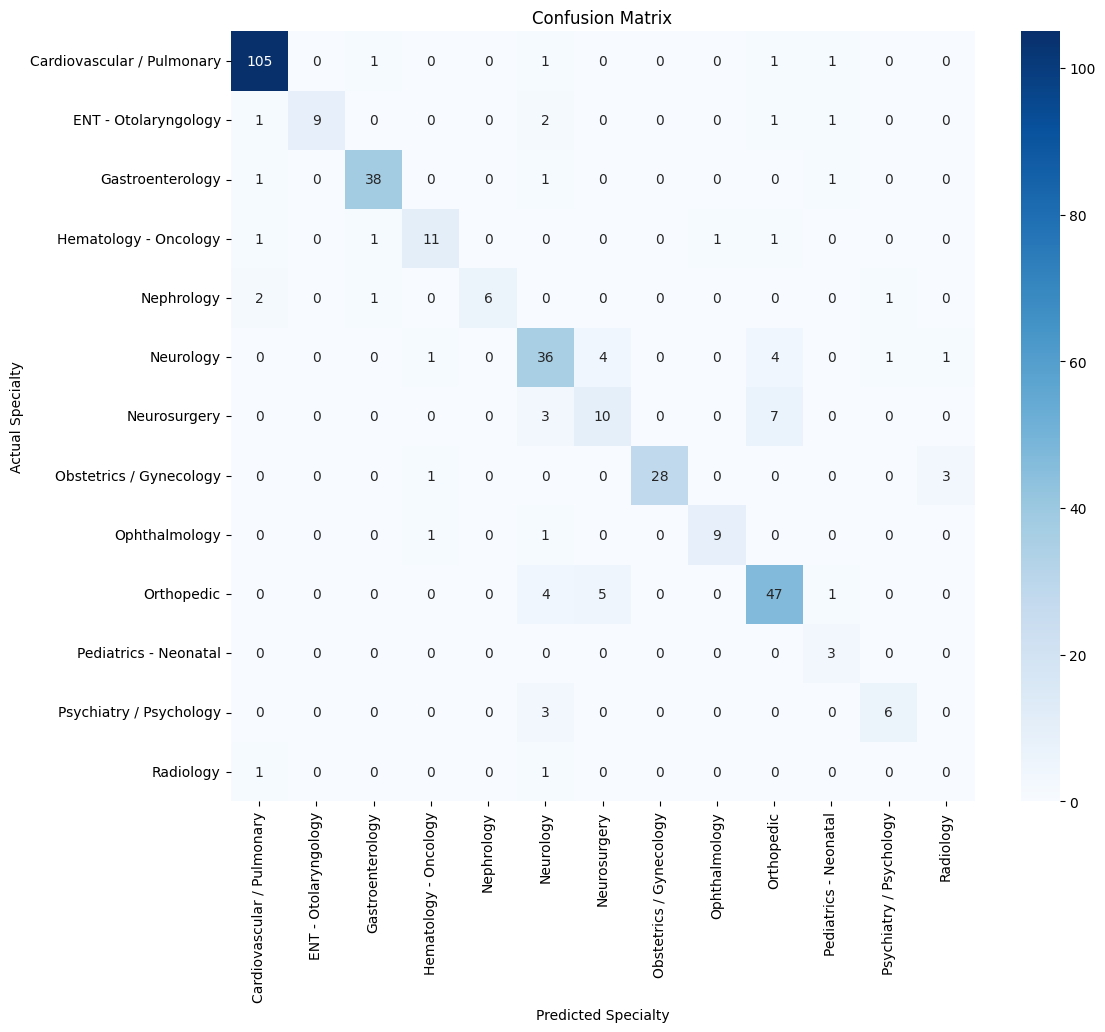

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = best_model.predict(df_test['combined_text'])
y_test_true = df_test['medical_specialty']

cm = confusion_matrix(y_test_true, y_test_pred, labels=best_model.classes_)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.ylabel("Actual Specialty")
plt.xlabel("Predicted Specialty")
plt.title("Confusion Matrix")
plt.show()


In [20]:
report = classification_report(y_test_true, y_test_pred, target_names=best_model.classes_)
print("📄 Classification Report:\n", report)

📄 Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.95      0.96      0.95       109
      ENT - Otolaryngology       1.00      0.64      0.78        14
          Gastroenterology       0.93      0.93      0.93        41
     Hematology - Oncology       0.79      0.73      0.76        15
                Nephrology       1.00      0.60      0.75        10
                 Neurology       0.69      0.77      0.73        47
              Neurosurgery       0.53      0.50      0.51        20
   Obstetrics / Gynecology       1.00      0.88      0.93        32
             Ophthalmology       0.90      0.82      0.86        11
                Orthopedic       0.77      0.82      0.80        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0.67      0.71         9
                 Radiology       0.00      0.00      0.00         2

                  ac

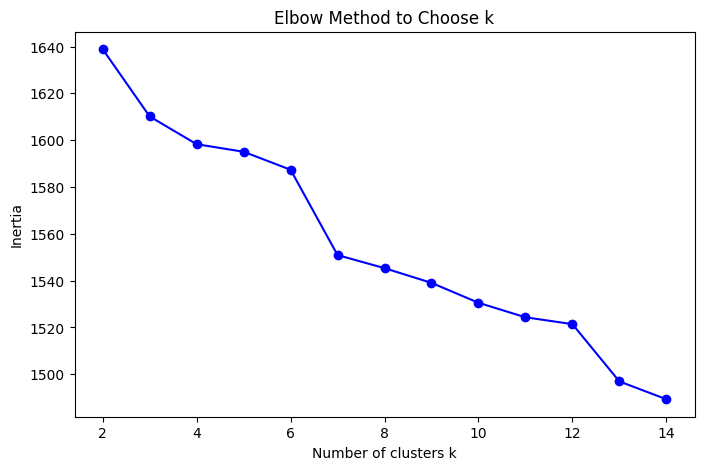

Cluster 0: nan, history, patient, nan nan, pain, report, past, year, time, normal
Cluster 1: artery, coronary, coronary artery, catheterization, angiography, pulmonary, catheter, right, stenosis, femoral
Cluster 2: pulmonary, atrial, cardiovascular pulmonary, valve, stress, cardiovascular, heart, chest, aortic, ventricular
Cluster 3: lobe, tumor, brain, pulmonary, mri, neurology, right, fetal, unremarkable, mass
Cluster 4: lumbar, l5, l4, disc, l4 l5, disk, s1, spinal, root, l5 s1
Cluster 5: cervical, anterior, discectomy, c5, patient, c6, fracture, orthopedic, c4, place
Cluster 6: sample reports, reports, sample, medical transcription, transcription sample, transcription, transcribed, accuracy quality, andare, andare reference
Cluster 7: knee, carpal, ligament, tunnel, tendon, carpal tunnel, medial, orthopedic, patella, meniscus
Cluster 8: history, nan, nan nan, patient, mg, daily, deny, past, pain, disease
Cluster 9: gastroenterology, laparoscopic, abdomen, colon, abdominal, uterus, 

In [21]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df_train['combined_text'])

inertia = []
K = range(2, 15)  # try 2–15 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose k")
plt.show()

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_tfidf)

# Cluster labels for each document
clusters = kmeans.labels_
df_train['cluster'] = clusters

terms = vectorizer.get_feature_names_out()

for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]  # top 10 words
    top_terms = [terms[ind] for ind in top_idx]
    print(f"Cluster {i}: {', '.join(top_terms)}")